<a href="https://colab.research.google.com/github/Arman001/marketing-with-ml/blob/main/Customer_Lifetime_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Lifetime Value with Machine Learning**

***
### **By:** Muhammad Saad
***


## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

## Load the dataset


In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
dataset = pd.read_excel(url)

In [ ]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Preprocessing

### Data Cleaning

In [ ]:
dataset.dropna(subset=['CustomerID'], inplace=True)  # Remove rows with missing CustomerID
dataset = dataset[dataset['Quantity'] > 0]  # Remove rows with negative or zero quantities
dataset['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'])  # Convert InvoiceDate to datetime format


In [ ]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Feature Engineering

In [ ]:
# Calculate TotalPrice = Quantity * UnitPrice
dataset['TotalPrice'] = dataset['Quantity'] * dataset['UnitPrice']

# RFM Analysis
current_date = dataset['InvoiceDate'].max()
rfm = dataset.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [ ]:
rfm

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40
...,...,...,...,...
4334,18280.0,277,1,180.60
4335,18281.0,180,1,80.82
4336,18282.0,7,2,178.05
4337,18283.0,3,16,2094.88


In [ ]:
# Handle outliers using Winsorizing (or alternatively could use IQR)
upper_limit = np.percentile(rfm['Monetary'], 99)
rfm['Monetary'] = np.where(rfm['Monetary'] > upper_limit, upper_limit, rfm['Monetary'])

In [ ]:
# Calculate CLV based on a refined approach
rfm['CLV'] = rfm['Monetary'] * rfm['Frequency'] * (1 / (rfm['Recency'] + 1))  # Avoid division by zero

# Reset the index of rfm after handling outliers and calculating CLV
rfm.reset_index(drop=True, inplace=True)

In [ ]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,CLV
0,12346.0,325,1,19880.0918,60.981877
1,12347.0,1,7,4310.0000,15085.000000
2,12348.0,74,4,1797.2400,95.852800
3,12349.0,18,1,1757.5500,92.502632
4,12350.0,309,1,334.4000,1.078710


<!-- ### Feature Scaling -->

In [ ]:

# # Normalize the RFM features

# scaler = StandardScaler()
# rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']]),
#                           columns=['Recency', 'Frequency', 'Monetary'])

# # Reset index of rfm_scaled
# rfm_scaled.reset_index(drop=True, inplace=True)

# # Add the CustomerID back to rfm_scaled
# rfm_scaled['CLV'] = rfm['CLV'].values

In [ ]:
# rfm_scaled.head()

,Recency,Frequency,Monetary,CLV
0,-0.911637,0.639161,1.374738,15085.000000
1,-0.182172,0.026855,0.183061,95.852800
2,-0.741762,-0.585450,0.164238,92.502632
3,2.166107,-0.585450,-0.510691,1.078710
4,-0.571886,0.843262,0.519210,556.897778


### Dataset Splititng into Traing & Testing

In [ ]:
# Split into features and target
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['CLV']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Random Forest Training


In [ ]:
# Create a Random Forest model with hyperparameter tuning using GridSearchCV
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Set up the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale data in the pipeline
    ('rf', RandomForestRegressor(random_state=42))
])

# Hyperparameter tuning with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 20, 30],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [ ]:
# Best model from grid search
best_rf = grid_search.best_estimator_

## Predictions

In [ ]:
# Make predictions on the test data
y_pred = best_rf.predict(X_test)

# Create a DataFrame to hold customer IDs and their predicted CLV
predicted_clv = pd.DataFrame({
    'CustomerID': rfm.loc[X_test.index, 'CustomerID'],  # Ensure this is correct
    'Predicted_CLV': y_pred,
    'Actual_CLV': y_test.values  # Add the actual CLV values
})

predicted_clv.head()


,CustomerID,Predicted_CLV,Actual_CLV
3976,17785.0,2.366163,2.489434
1448,14317.0,7.207134,7.824308
2663,15977.0,121.609362,124.085882
17,12364.0,649.665298,656.550000
1634,14565.0,119.987253,129.130000


## Evaluate the Model

In [ ]:
# Calculate RMSE and other metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

Best Parameters: {'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
RMSE: 13169.644073565947
MAE: 1326.6149084092763
R²: 0.9666784877888426


In [ ]:
grid_search.cv_results_

In [ ]:
# Create the predicted_clv DataFrame
predicted_clv = pd.DataFrame({
    'CustomerID': rfm.loc[X_test.index, 'CustomerID'],  # Ensure this is correct
    'Predicted_CLV': y_pred,
    'Actual_CLV': y_test.values  # Add the actual CLV values
})

predicted_clv.head()

# Define CLV segments based on quantiles (quartiles in this case)
quantiles = predicted_clv['Predicted_CLV'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist()

# Function to assign segments based on predicted CLV
def assign_segment(clv):
    if clv <= quantiles[1]:
        return 'Low Value'
    elif clv <= quantiles[2]:
        return 'Medium Value'
    elif clv <= quantiles[3]:
        return 'High Value'
    else:
        return 'Very High Value'

# Create a new column for segments
predicted_clv['CLV_Segment'] = predicted_clv['Predicted_CLV'].apply(assign_segment)

# Display the updated DataFrame with segments
predicted_clv.head()


,CustomerID,Predicted_CLV,Actual_CLV,CLV_Segment
3976,17785.0,2.366163,2.489434,Low Value
1448,14317.0,7.207134,7.824308,Medium Value
2663,15977.0,121.609362,124.085882,High Value
17,12364.0,649.665298,656.550000,Very High Value
1634,14565.0,119.987253,129.130000,High Value


In [ ]:
# Analyze the segments
segment_analysis = predicted_clv.groupby('CLV_Segment').agg({
    'CustomerID': 'count',
    'Predicted_CLV': 'mean',
    'Actual_CLV': 'mean'  # If you want to compare with actual values
}).reset_index()

# Rename columns for clarity
segment_analysis.columns = ['CLV_Segment', 'Customer_Count', 'Average_Predicted_CLV', 'Average_Actual_CLV']

# Display segment analysis
segment_analysis

,CLV_Segment,Customer_Count,Average_Predicted_CLV,Average_Actual_CLV
0,High Value,217,143.235785,137.526688
1,Low Value,217,1.658268,1.627425
2,Medium Value,217,14.524872,14.024453
3,Very High Value,217,28118.116362,30107.501066


## Visualizing Results

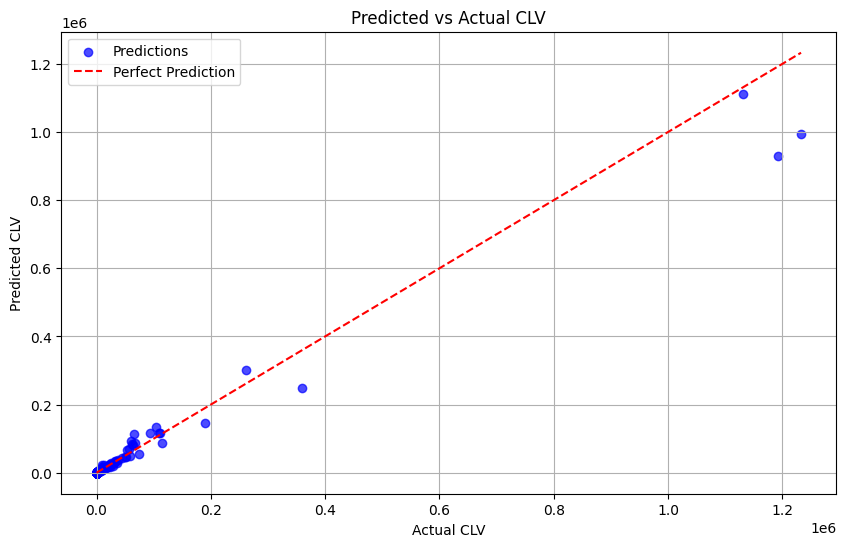

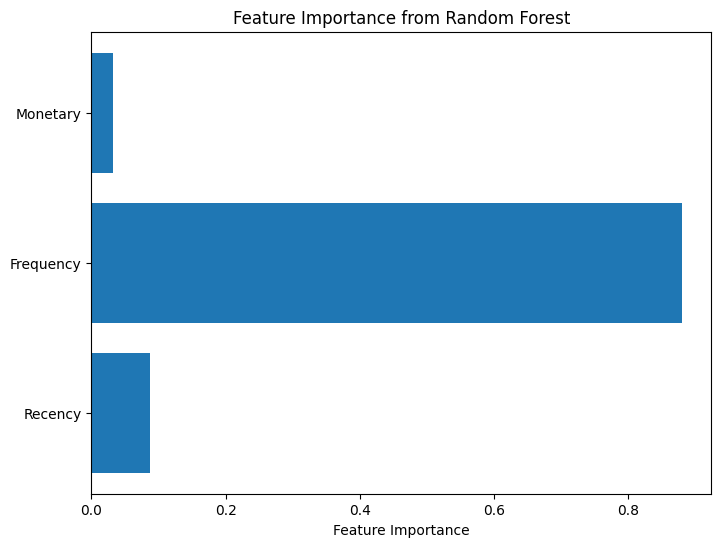

In [ ]:
# Visualizing Predicted vs Actual CLV
plt.figure(figsize=(10, 6))
plt.scatter(predicted_clv['Actual_CLV'], predicted_clv['Predicted_CLV'], alpha=0.7, color='blue', label='Predictions')
plt.plot([predicted_clv['Actual_CLV'].min(), predicted_clv['Actual_CLV'].max()],
         [predicted_clv['Actual_CLV'].min(), predicted_clv['Actual_CLV'].max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs Actual CLV')
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.grid()
plt.legend()
plt.show()

# Optionally, visualize feature importance
if hasattr(best_rf.named_steps['rf'], 'feature_importances_'):
    importances = best_rf.named_steps['rf'].feature_importances_
    feature_names = ['Recency', 'Frequency', 'Monetary']

    plt.figure(figsize=(8, 6))
    plt.barh(feature_names, importances)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance from Random Forest')
    plt.show()